In [97]:
%config IPCompleter.greedy=True
%autosave 30
import warnings
warnings.filterwarnings('ignore')

Autosaving every 30 seconds


In [98]:
# libraries
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale

In [99]:
telco = pd.read_csv("telecom_churn_data.csv")

In [100]:
telco.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


# Step1 - Data Pre-processing

## Step1a - Filtering out the HVI - whose recharge amount >= 70th percentile of recharge amount in 6,7

In [101]:
#check if any total recharge amount columns has nulls
round((telco[['total_rech_amt_6','total_rech_amt_7']].isnull().sum(axis=0)/telco.shape[0])*100,2).sort_values(ascending=False)

total_rech_amt_7    0.0
total_rech_amt_6    0.0
dtype: float64

#### No nulls in these columns, hence can be used for HVI extraction

In [102]:
telco['tot_rech_amt_6_7']=telco['total_rech_amt_6']+telco['total_rech_amt_7']
pcntlcutoff=telco['tot_rech_amt_6_7'].quantile(0.7)
HVItelco=telco.loc[telco['tot_rech_amt_6_7']>=pcntlcutoff]
print(pcntlcutoff)
print(HVItelco.info())

737.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30011 entries, 7 to 99997
Columns: 227 entries, mobile_number to tot_rech_amt_6_7
dtypes: float64(179), int64(36), object(12)
memory usage: 52.2+ MB
None


## Step 1b - NULL DATA HANDLING

#### Find the list of columns
    - with highest null %
    - unique counts
    - entry that is most frequent (mode)

In [103]:
Nulllist = pd.DataFrame()
Nulllist['columns']=HVItelco.columns
Nulllist['nullpcnt']=list(round((HVItelco.isnull().sum(axis=0)/HVItelco.shape[0])*100,2))
Nulllist['uniquecnt']=list(HVItelco.nunique())
Nulllist['dtype']=Nulllist['columns'].apply(lambda x: HVItelco[x].dtype)

In [104]:
Nulllist['mode']=Nulllist['columns'].apply(lambda x: HVItelco[x].nunique())
Nulllist['mode']=Nulllist['columns'].apply(lambda x: HVItelco[x].mode())

In [105]:
Nulllist.sort_values(by=['nullpcnt'],ascending=False)

,columns,nullpcnt,uniquecnt,dtype,mode
189,arpu_3g_6,62.02,4875,float64,0
173,count_rech_3g_6,62.02,25,float64,0
217,fb_user_6,62.02,2,float64,1
193,arpu_2g_6,62.02,4503,float64,0
197,night_pck_user_6,62.02,2,float64,0
157,date_of_last_rech_data_6,62.02,30,object,6/30/2014
161,total_rech_data_6,62.02,36,float64,1
165,max_rech_data_6,62.02,43,float64,154
177,av_rech_amt_data_6,62.02,794,float64,154
169,count_rech_2g_6,62.02,30,float64,1


### Handling numerical nulls

In [106]:
#extract all columns with numerical values and corresponding mode
Issue_cols_num_vars=(Nulllist.loc[(Nulllist['nullpcnt']>0) & (Nulllist['dtype'] != "object"),['columns']])
Issue_cols_num_rplc=(Nulllist.loc[(Nulllist['nullpcnt']>0) & (Nulllist['dtype'] != "object"),['mode']])
Issue_cols_num=pd.concat([Issue_cols_num_vars,Issue_cols_num_rplc],axis=1)

In [107]:
Issue_cols_num.sort_values(by=['mode'],ascending=False)

,columns,mode
168,max_rech_data_9,252
167,max_rech_data_8,252
166,max_rech_data_7,252
180,av_rech_amt_data_9,252
165,max_rech_data_6,154
177,av_rech_amt_data_6,154
178,av_rech_amt_data_7,154
179,av_rech_amt_data_8,154
169,count_rech_2g_6,1
170,count_rech_2g_7,1


### In the above set, we can see that all variables having null values should contain 0 as the null indicates no activity

In [108]:
#revised dataset with null handled
HVItelco1=HVItelco

In [109]:
for index, row in Issue_cols_num.iterrows():
    col=row['columns']
    val=0.0
    HVItelco1[col].fillna(val,inplace=True)

In [110]:
round((HVItelco1.isnull().sum(axis=0)/HVItelco1.shape[0])*100,2).sort_values(ascending=False)

date_of_last_rech_data_6    62.02
date_of_last_rech_data_9    61.81
date_of_last_rech_data_7    61.14
date_of_last_rech_data_8    60.83
date_of_last_rech_9          2.89
date_of_last_rech_8          1.98
last_date_of_month_9         1.20
last_date_of_month_8         0.52
date_of_last_rech_7          0.38
date_of_last_rech_6          0.21
last_date_of_month_7         0.10
isd_og_mou_6                 0.00
spl_og_mou_7                 0.00
spl_og_mou_6                 0.00
isd_og_mou_9                 0.00
isd_og_mou_8                 0.00
isd_og_mou_7                 0.00
spl_og_mou_8                 0.00
spl_og_mou_9                 0.00
og_others_6                  0.00
tot_rech_amt_6_7             0.00
std_og_mou_8                 0.00
std_og_mou_9                 0.00
og_others_8                  0.00
std_og_mou_7                 0.00
std_og_mou_6                 0.00
std_og_t2c_mou_9             0.00
std_og_t2c_mou_8             0.00
std_og_t2c_mou_7             0.00
std_og_t2c_mou

### Handling object variables

In [111]:
#extract all columns with object values
Issue_cols_obj=(Nulllist.loc[(Nulllist['nullpcnt']>0) & (Nulllist['dtype'] == "object"),['columns']])

In [112]:
Issue_cols_obj

,columns
6,last_date_of_month_7
7,last_date_of_month_8
8,last_date_of_month_9
149,date_of_last_rech_6
150,date_of_last_rech_7
151,date_of_last_rech_8
152,date_of_last_rech_9
157,date_of_last_rech_data_6
158,date_of_last_rech_data_7
159,date_of_last_rech_data_8


#### All are date fields, hence defaulting them to "0/0/0

In [113]:
for index, row in Issue_cols_obj.iterrows():
    col=row['columns']
    HVItelco1[col].fillna("0/0/0",inplace=True)

In [114]:
round((HVItelco1.isnull().sum(axis=0)/HVItelco1.shape[0])*100,2).sort_values(ascending=False)

tot_rech_amt_6_7            0.0
std_og_t2m_mou_9            0.0
total_og_mou_7              0.0
total_og_mou_6              0.0
og_others_9                 0.0
og_others_8                 0.0
og_others_7                 0.0
og_others_6                 0.0
spl_og_mou_9                0.0
spl_og_mou_8                0.0
spl_og_mou_7                0.0
spl_og_mou_6                0.0
isd_og_mou_9                0.0
isd_og_mou_8                0.0
isd_og_mou_7                0.0
isd_og_mou_6                0.0
std_og_mou_9                0.0
std_og_mou_8                0.0
std_og_mou_7                0.0
std_og_mou_6                0.0
std_og_t2c_mou_9            0.0
std_og_t2c_mou_8            0.0
std_og_t2c_mou_7            0.0
std_og_t2c_mou_6            0.0
std_og_t2f_mou_9            0.0
std_og_t2f_mou_8            0.0
std_og_t2f_mou_7            0.0
total_og_mou_8              0.0
total_og_mou_9              0.0
loc_ic_t2t_mou_6            0.0
                           ... 
std_ic_t

#### All null values are handled

## STEP 1b - Create Churn Labels

The following are to be considered for identification of churners
 - total_ic_mou_9
 - total_og_mou_9
 - vol_2g_mb_9
 - vol_3g_mb_9

In [115]:
HVItelco1[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']]

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
13,631.86,446.09,0.00,0.00
16,334.56,255.74,0.00,0.00
17,87.13,631.08,0.00,0.00
21,252.61,1031.53,0.00,0.00
24,330.03,627.78,0.00,0.00
33,114.16,1.70,30.92,5588.11
38,114.09,708.04,0.00,0.00
41,165.84,89.13,0.00,0.00


### Add all the usage values and see if the sum is 0. if yes, then set churn indicator else do not set

In [116]:
HVItelco1['churncheck']=HVItelco1['total_ic_mou_9']+HVItelco1['total_og_mou_9']+HVItelco1['vol_2g_mb_9']+HVItelco1['vol_3g_mb_9']
HVItelco1['churn']=HVItelco['churncheck'].apply(lambda x: 1 if x == 0.0 else 0)

In [117]:
HVItelco1['churn']

7        1
8        0
13       0
16       0
17       0
21       0
24       0
33       0
38       0
41       0
48       0
53       0
56       0
57       0
60       0
61       0
69       0
73       0
74       0
77       0
87       0
92       0
96       0
97       1
101      0
102      0
103      0
105      0
111      1
115      0
        ..
99887    1
99893    0
99896    0
99899    0
99902    0
99904    0
99921    0
99922    0
99923    0
99924    0
99925    0
99927    0
99929    0
99931    0
99932    0
99935    0
99937    0
99939    0
99941    0
99943    0
99957    0
99959    0
99961    1
99963    0
99965    0
99970    0
99974    0
99986    0
99988    0
99997    0
Name: churn, Length: 30011, dtype: int64

## Step1C - Drop all columns related to 9th month and churn checker

In [118]:
col_9mnth=list(HVItelco1.filter(like='_9').columns)
col_9mnth.append('churncheck')
col_9mnth.append('sep_vbc_3g')
HVItelco1.drop(col_9mnth,axis=1,inplace=True)

In [119]:
HVItelco1.columns

Index(['mobile_number', 'circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou',
       'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7',
       'last_date_of_month_8', 'arpu_6', 'arpu_7',
       ...
       'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'tot_rech_amt_6_7', 'churn'],
      dtype='object', length=173)

### Step 1D - check for columns without any data diversity

In [120]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    print(Nulllist.sort_values(by=['uniquecnt','columns'],ascending=True))
#display(Nulllist.sort_values(by=['uniquecnt','columns'],ascending=True))

                      columns  nullpcnt  uniquecnt    dtype        mode
1                   circle_id      0.00          1    int64         109
5        last_date_of_month_6      0.00          1   object   6/30/2014
6        last_date_of_month_7      0.10          1   object   7/31/2014
7        last_date_of_month_8      0.52          1   object   8/31/2014
8        last_date_of_month_9      1.20          1   object   9/30/2014
4              loc_ic_t2o_mou      0.38          1  float64           0
2              loc_og_t2o_mou      0.38          1  float64           0
113          std_ic_t2o_mou_6      1.05          1  float64           0
114          std_ic_t2o_mou_7      1.01          1  float64           0
115          std_ic_t2o_mou_8      3.13          1  float64           0
116          std_ic_t2o_mou_9      5.68          1  float64           0
61           std_og_t2c_mou_6      1.05          1  float64           0
62           std_og_t2c_mou_7      1.01          1  float64     

In [121]:
#drop all columns with no data diversity, where only one value is present
droplist=Nulllist.loc[Nulllist['uniquecnt']==1,['columns']]
droplistc=list(droplist['columns'])
droplistc
droplistc.remove('last_date_of_month_9')
droplistc.remove('std_ic_t2o_mou_9')
droplistc.remove('std_og_t2c_mou_9')
HVItelco1.drop(droplistc,axis=1,inplace=True)

## Categorical variables - fb_user and night_pck_user
No other variables are categorical indicator variables.
These two variables are binary and has 0/1 as their values; hence dummy is not required

# Step2 - EDA and Feature Engineering

In [122]:
HVItelco1.columns

Index(['mobile_number', 'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7',
       'offnet_mou_8',
       ...
       'sachet_3g_8', 'fb_user_6', 'fb_user_7', 'fb_user_8', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g', 'tot_rech_amt_6_7', 'churn'],
      dtype='object', length=160)

In [123]:
HVItelco1.rename(columns={'aug_vbc_3g':'vbc_3g_8',
                          'jul_vbc_3g':'vbc_3g_7',
                          'jun_vbc_3g':'vbc_3g_6'},inplace=True)

In [124]:
# list of KPIs for each month
KPI=pd.DataFrame()
KPI['KPI']=list(HVItelco1.filter(like='_6').columns)
KPI['KPI']=KPI['KPI'].apply(lambda x: x[:-2])
KPI_=list(KPI['KPI'])
KPI_.remove('tot_rech_amt_6')
KPI_.remove('date_of_last_rech')
KPI_.remove('date_of_last_rech_data')
print(KPI_)
print(len(KPI_))

['arpu', 'onnet_mou', 'offnet_mou', 'roam_ic_mou', 'roam_og_mou', 'loc_og_t2t_mou', 'loc_og_t2m_mou', 'loc_og_t2f_mou', 'loc_og_t2c_mou', 'loc_og_mou', 'std_og_t2t_mou', 'std_og_t2m_mou', 'std_og_t2f_mou', 'std_og_mou', 'isd_og_mou', 'spl_og_mou', 'og_others', 'total_og_mou', 'loc_ic_t2t_mou', 'loc_ic_t2m_mou', 'loc_ic_t2f_mou', 'loc_ic_mou', 'std_ic_t2t_mou', 'std_ic_t2m_mou', 'std_ic_t2f_mou', 'std_ic_mou', 'total_ic_mou', 'spl_ic_mou', 'isd_ic_mou', 'ic_others', 'total_rech_num', 'total_rech_amt', 'max_rech_amt', 'last_day_rch_amt', 'total_rech_data', 'max_rech_data', 'count_rech_2g', 'count_rech_3g', 'av_rech_amt_data', 'vol_2g_mb', 'vol_3g_mb', 'arpu_3g', 'arpu_2g', 'night_pck_user', 'monthly_2g', 'sachet_2g', 'monthly_3g', 'sachet_3g', 'fb_user', 'vbc_3g']
50


### Month wise Numerical KPI - exploration and trend analysis

In [125]:
HVItelco1_analysis=HVItelco1.groupby('churn')

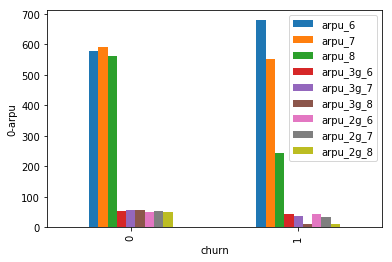

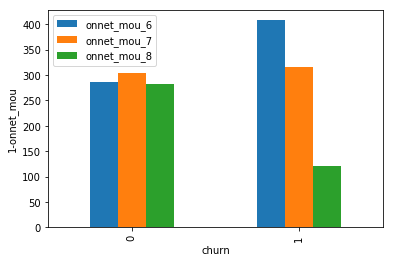

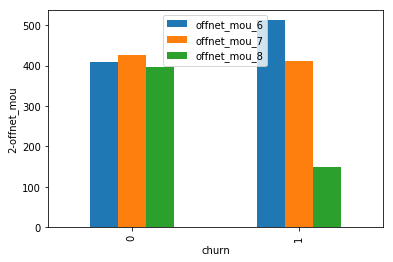

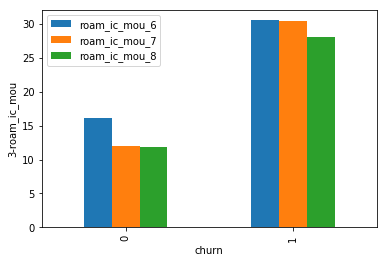

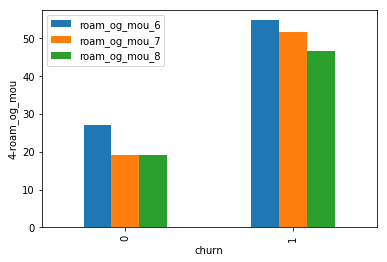

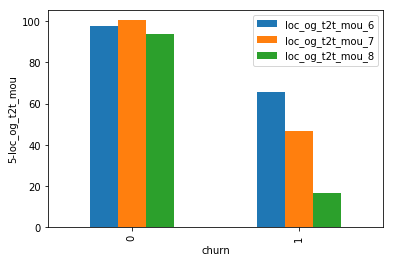

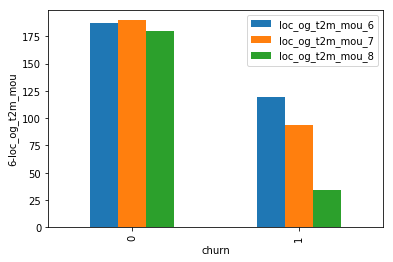

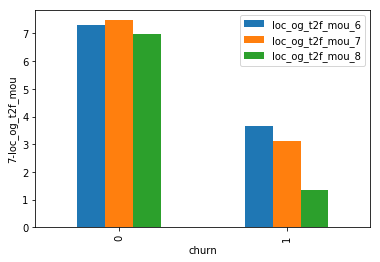

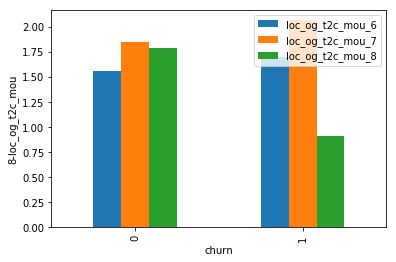

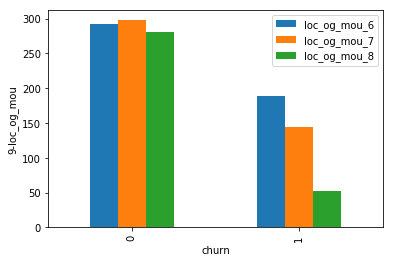

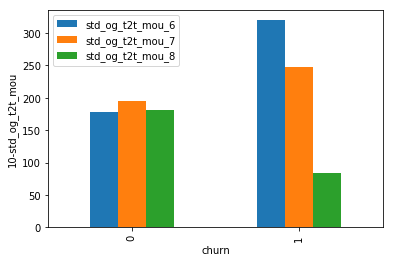

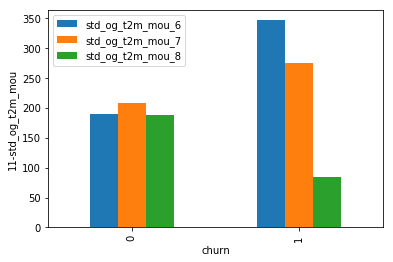

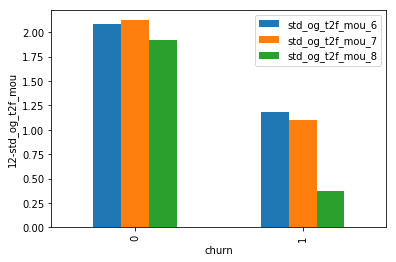

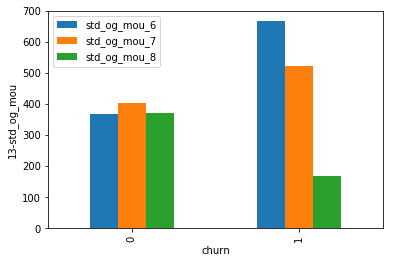

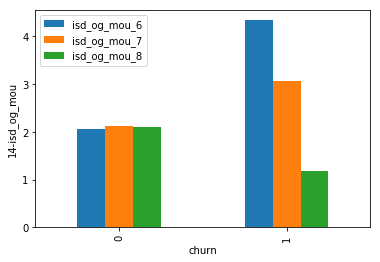

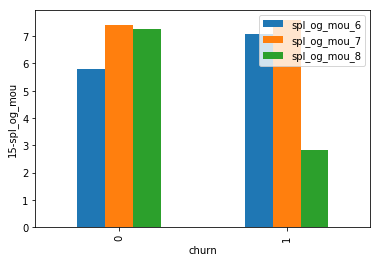

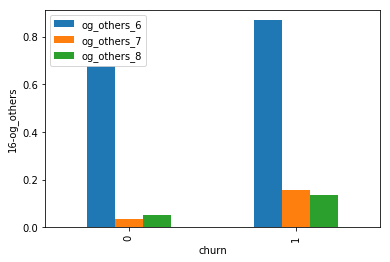

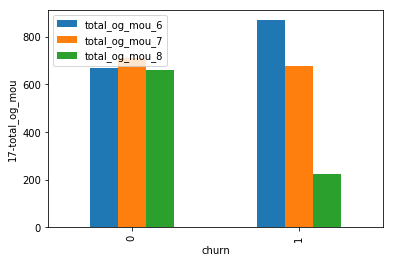

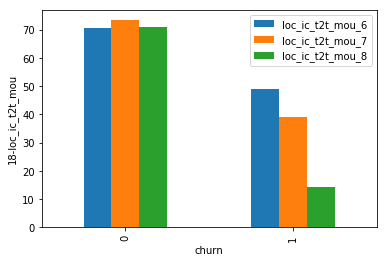

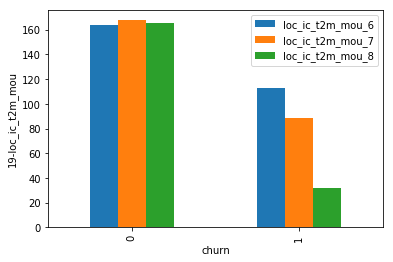

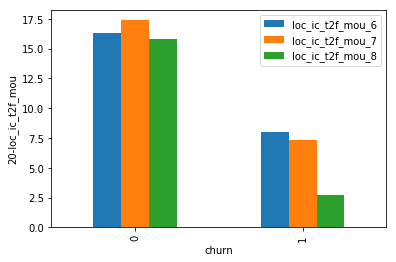

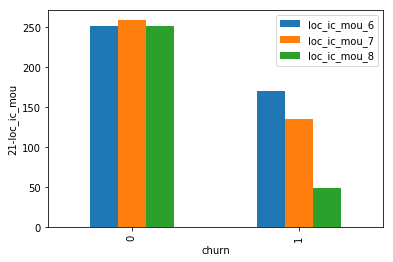

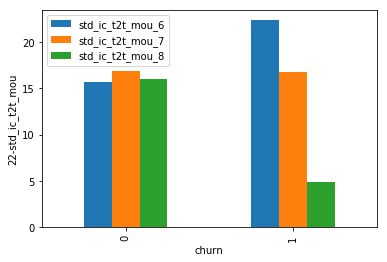

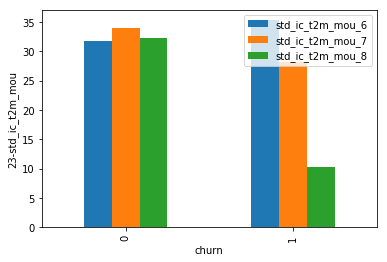

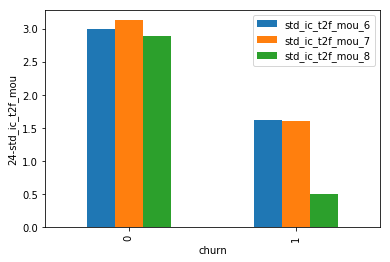

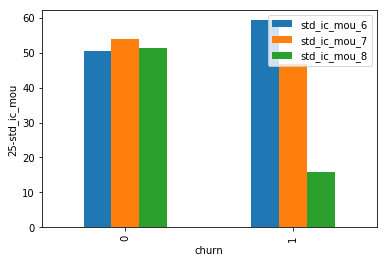

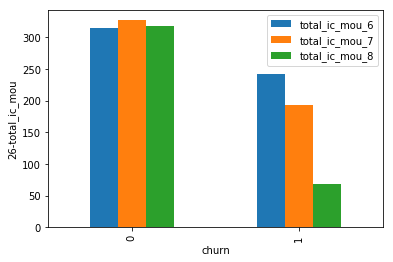

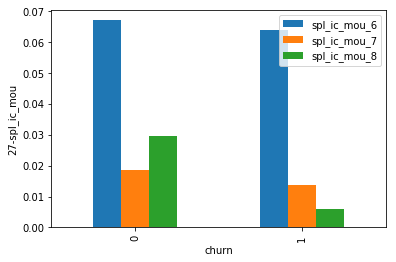

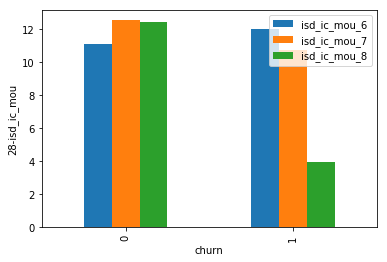

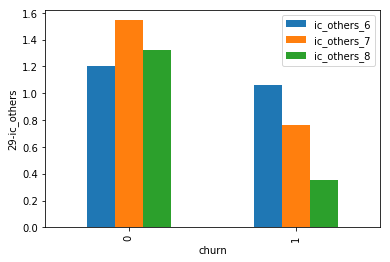

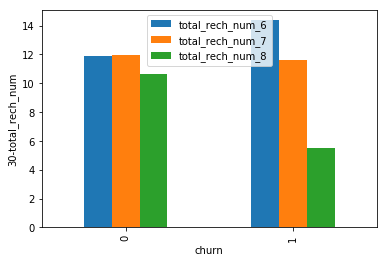

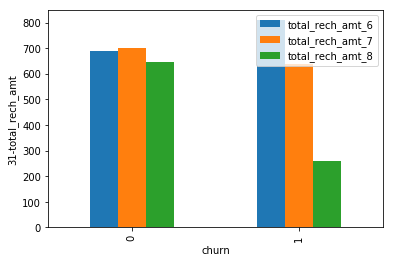

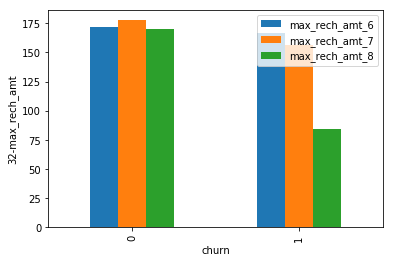

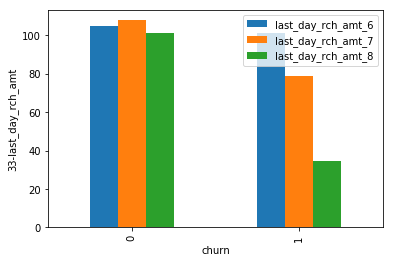

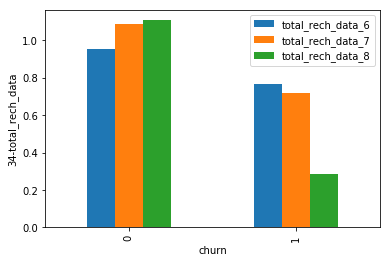

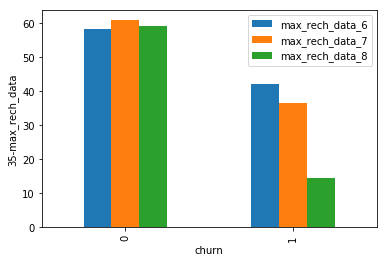

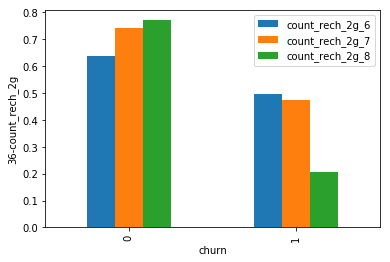

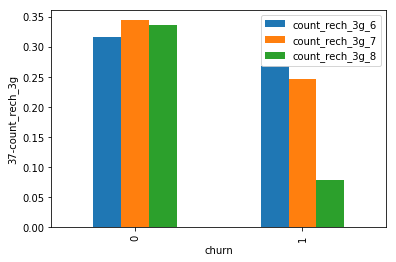

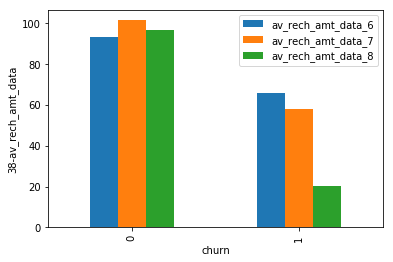

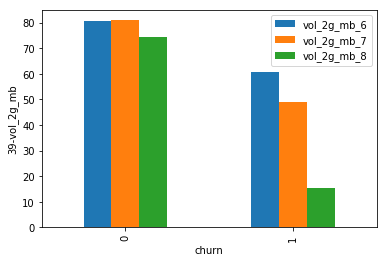

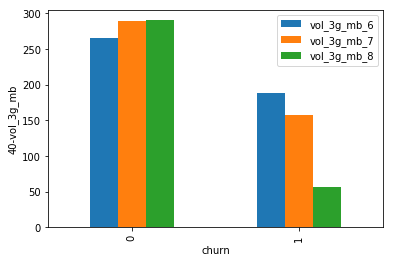

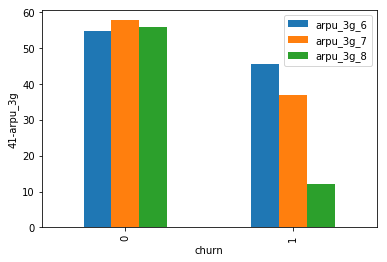

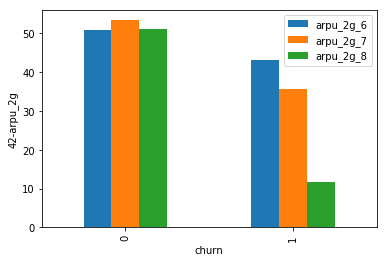

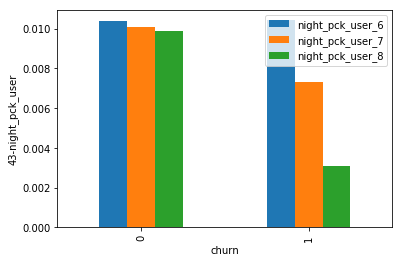

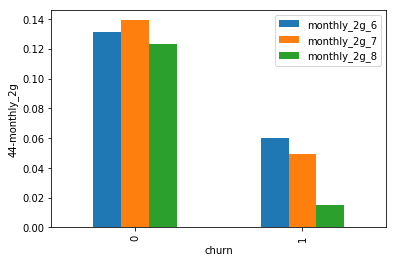

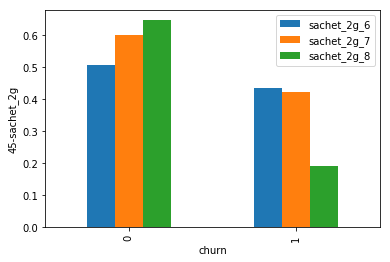

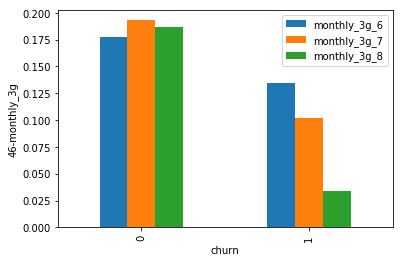

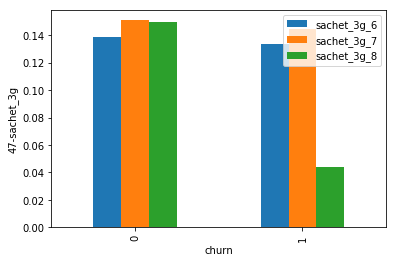

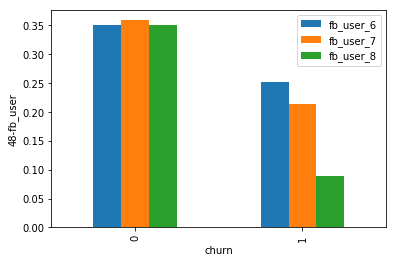

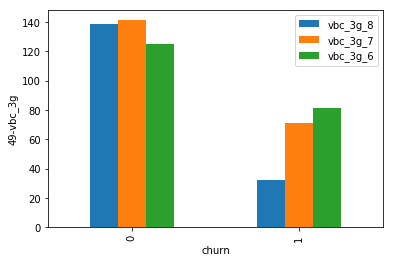

IndexError: list index out of range

In [126]:
HVItelco1_analysis=HVItelco1.groupby('churn')
count=0
for i in range(17):
    for j in range(3):
        cols=list(HVItelco1.filter(like=KPI_[count]).columns)
        plotdata=HVItelco1_analysis[cols].mean()
        plt.figure
        plotdata.plot.bar()
        plt.ylabel(str(count)+"-"+str(KPI_[count]))
        plt.show()
        count=count+1

In [127]:
KPI_date=pd.DataFrame()
KPI_date['KPI']=list(HVItelco1.filter(like='date_of_last_rech').columns)
print(HVItelco1[KPI_date['KPI']].head())

   date_of_last_rech_6 date_of_last_rech_7 date_of_last_rech_8  \
7            6/27/2014           7/25/2014           8/26/2014   
8            6/25/2014           7/31/2014           8/30/2014   
13           6/20/2014           7/22/2014           8/30/2014   
16           6/30/2014           7/31/2014           8/14/2014   
17           6/30/2014           7/30/2014           8/25/2014   

   date_of_last_rech_data_6 date_of_last_rech_data_7 date_of_last_rech_data_8  
7                     0/0/0                    0/0/0                    0/0/0  
8                     0/0/0                7/31/2014                8/23/2014  
13                    0/0/0                    0/0/0                8/30/2014  
16                    0/0/0                    0/0/0                    0/0/0  
17                    0/0/0                    0/0/0                    0/0/0  


In [128]:
HVItelco1['day_of_last_rech_6']=HVItelco1['date_of_last_rech_6'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_7']=HVItelco1['date_of_last_rech_7'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_8']=HVItelco1['date_of_last_rech_8'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_data_6']=HVItelco1['date_of_last_rech_data_6'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_data_7']=HVItelco1['date_of_last_rech_data_7'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_data_8']=HVItelco1['date_of_last_rech_data_8'].apply(lambda x:x.split("/")[1])
HVItelco1['day_of_last_rech_6']=HVItelco1['day_of_last_rech_6'].astype(int)
HVItelco1['day_of_last_rech_7']=HVItelco1['day_of_last_rech_7'].astype(int)
HVItelco1['day_of_last_rech_8']=HVItelco1['day_of_last_rech_8'].astype(int)
HVItelco1['day_of_last_rech_data_6']=HVItelco1['day_of_last_rech_data_6'].astype(int)
HVItelco1['day_of_last_rech_data_7']=HVItelco1['day_of_last_rech_data_7'].astype(int)
HVItelco1['day_of_last_rech_data_8']=HVItelco1['day_of_last_rech_data_8'].astype(int)

In [129]:
HVItelco1.head()

,mobile_number,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,vbc_3g_7,vbc_3g_6,tot_rech_amt_6_7,churn,day_of_last_rech_6,day_of_last_rech_7,day_of_last_rech_8,day_of_last_rech_data_6,day_of_last_rech_data_7,day_of_last_rech_data_8
7,7000701601,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,...,19.38,18.74,2370,1,27,25,26,0,0,0
8,7001524846,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,...,910.65,122.16,1038,0,25,31,30,0,31,23
13,7002191713,492.846,205.671,593.260,501.76,108.39,534.24,413.31,119.28,482.46,...,0.00,0.00,760,0,20,22,30,0,0,30
16,7000875565,430.975,299.869,187.894,50.51,74.01,70.61,296.29,229.74,162.76,...,2.45,21.89,918,0,30,31,14,0,0,0
17,7000187447,690.008,18.980,25.499,1185.91,9.28,7.79,61.64,0.00,5.54,...,0.00,0.00,816,0,30,30,25,0,0,0


In [130]:
KPI_date=pd.DataFrame()
KPI_date['KPI']=list(HVItelco1.filter(like='day_of_last_rech').columns)
KPI_date_=list(KPI_date['KPI'])
KPI_date_

['day_of_last_rech_6',
 'day_of_last_rech_7',
 'day_of_last_rech_8',
 'day_of_last_rech_data_6',
 'day_of_last_rech_data_7',
 'day_of_last_rech_data_8']

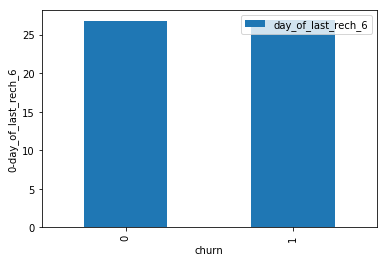

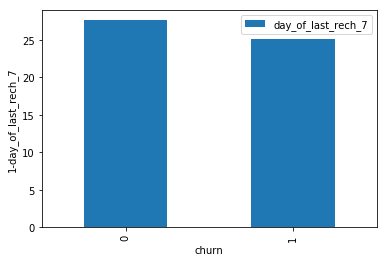

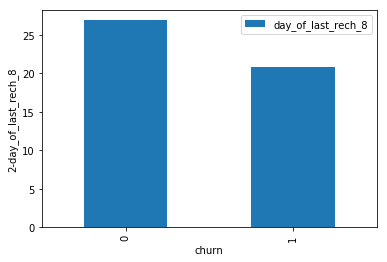

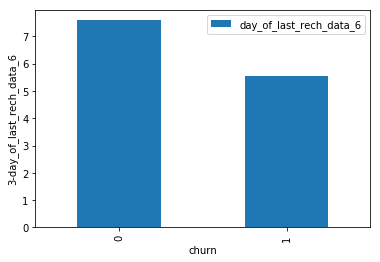

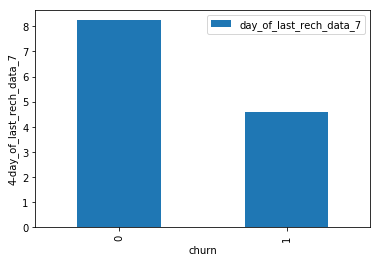

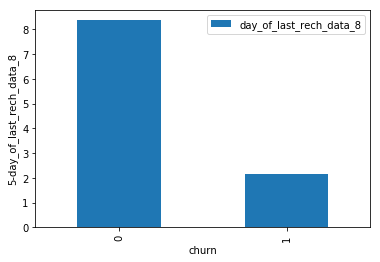

In [131]:
HVItelco1_analysis=HVItelco1.groupby('churn')
count=0
for i in range(6):
        cols=list(HVItelco1.filter(like=KPI_date_[count]).columns)
        plotdata=HVItelco1_analysis[cols].mean()
        plt.figure
        plotdata.plot.bar()
        plt.ylabel(str(count)+"-"+str(KPI_date_[count]))
        plt.show()
        count=count+1

# ********************* PREDICTION MODEL BUILDING ***************

# CLASS IMBALANCE HANDLING

In [132]:
print(HVItelco['churn'].describe())
print(HVItelco['churn'].value_counts())

count    30011.000000
mean         0.086402
std          0.280961
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64
0    27418
1     2593
Name: churn, dtype: int64


#### ~8% only churn data available

### Applying downsampling of dominant variable for balancing. Target balance ratio - 40 - 60

In [234]:
from sklearn.utils import resample

# Separate majority and minority classes
HVItelco_majority = HVItelco[HVItelco.churn==0]
HVItelco_minority = HVItelco[HVItelco.churn==1]
 
# Downsample majority class
HVItelco_majority_downsampled = resample(HVItelco_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3889,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
HVItelco_downsampled = pd.concat([HVItelco_majority_downsampled, HVItelco_minority])
 
# Display new class counts
HVItelco_downsampled.churn.value_counts()

0    3889
1    2593
Name: churn, dtype: int64

## Final dataset preparation

In [186]:
y=HVItelco_downsampled['churn']
X=HVItelco_downsampled
X.drop('churn',axis=1,inplace=True)

In [187]:
delcols=list(HVItelco1.filter(like='date_of_last_rech').columns)
delcols.append('mobile_number')
X.drop(delcols,axis=1,inplace=True)

### Standardization

In [188]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [189]:
#HousePrice_numericals[numerical_vars]=scaler.fit_transform(HousePrice_numericals[numerical_vars])
X=scaler.fit_transform(X)

# TEST - TRAIN SPLIT

In [190]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

# PCA 

In [191]:
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized')

In [192]:
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [193]:
hopkins(HVItelco_downsampled)

0.96306499827975911

### 96% Hopkins Score signifies very high potential for classification

In [194]:
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

In [195]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.45103946,  0.54703936,  0.60979621,  0.66307308,  0.70121405,
        0.73094478,  0.7558358 ,  0.77526501,  0.793717  ,  0.81070465,
        0.82705084,  0.84065645,  0.85281069,  0.86301277,  0.87270526,
        0.88120158,  0.88908248,  0.89664454,  0.90291934,  0.90856672,
        0.91301749,  0.91703604,  0.92070102,  0.92426099,  0.92763519,
        0.93068127,  0.93366001,  0.93649219,  0.93917616,  0.94182814,
        0.94438363,  0.94674442,  0.94905908,  0.95128232,  0.95327627,
        0.95521238,  0.9571    ,  0.95890909,  0.9606851 ,  0.96233509,
        0.96392413,  0.96549925,  0.96703537,  0.96844279,  0.96969404,
        0.97091973,  0.97213019,  0.97330491,  0.97444742,  0.97552134,
        0.97652911,  0.97751854,  0.97844512,  0.97934931,  0.98022775,
        0.98103945,  0.98182762,  0.98259319,  0.98332413,  0.98400453,
        0.98466117,  0.98529938,  0.98591296,  0.98651252,  0.98709022,
        0.98763374,  0.98816821,  0.98868229,  0.98917469,  0.98

#### 22 components giving ~90% data variance
#### 30 components giving ~95% data variance

## PCA final

In [196]:
pca_final=PCA(n_components=30)
X_train_pca=pca_final.fit_transform(X_train)
print(X_train_pca.shape)
print(X_train_pca)

(4537, 30)
[[ -6.24830312e-01  -3.04738671e-03  -2.08436309e-02 ...,  -2.80505876e-02
    1.35058635e-01   3.47602084e-02]
 [  1.71725802e+00  -2.63562415e-01   1.98568389e-01 ...,   9.19493818e-02
    3.04530989e-02  -1.97964083e-01]
 [ -6.36640922e-01  -5.13964678e-02  -3.14321607e-02 ...,   1.08996867e-02
   -6.55595609e-03   1.24473735e-02]
 ..., 
 [  1.02212898e+00   9.50397666e-01  -4.63102168e-01 ...,   4.45319057e-02
   -1.65014692e-01  -6.07830366e-02]
 [ -6.18177782e-01  -3.50155021e-02  -2.55465213e-02 ...,   1.01224535e-02
    1.54490945e-03   1.20722181e-03]
 [  1.14648820e-01  -2.07634000e-01  -6.57539581e-01 ...,   5.58026544e-02
   -5.51810301e-03   1.06127727e-02]]


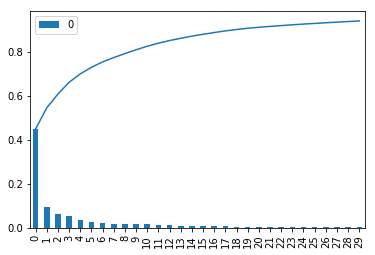

In [197]:
PCAF_EVR=pd.DataFrame(pca_final.explained_variance_ratio_)
PCAF_EVR.plot.bar()
plt.plot(np.cumsum(pca_final.explained_variance_ratio_))

# Logistic Regression based churn prediction

In [198]:
#Training the model on the train data
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

learner_pca = LogisticRegression()
model_pca = learner_pca.fit(X_train_pca,y_train)

In [199]:
df_test_pca = pca_final.transform(X_test)
df_test_pca.shape

(1945, 30)

In [200]:
#Making prediction on the test data
pred_probs_test = model_pca.predict_proba(df_test_pca)[:,1]
"{:2.2}".format(metrics.roc_auc_score(y_test, pred_probs_test))

'0.88'

### Logit Reg - Parameter tuning and actual churn label prediction

In [201]:
y_pred=pd.DataFrame(pred_probs_test)
y_pred.columns=['Score']
y_pred['Score']=y_pred['Score'].apply(lambda x:round(x*100),0)
y_test_pd=pd.DataFrame(y_test)
y_pred.reset_index(drop=True, inplace=True)
y_test_pd.reset_index(drop=True, inplace=True)
# Appending y_test_df and y_pred_1
y_pred_final = pd.concat([y_pred, y_test_pd],axis=1)
y_pred_final.head()

,Score,churn
0,79,1
1,24,0
2,49,1
3,34,0
4,5,0


In [202]:
## Optimal Cutoff Analysis
numbers = np.around(np.linspace(0, 100, 100),decimals=0)
for i in numbers:
    y_pred_final[i]= y_pred_final.Score.map(lambda x: 1 if x > i else 0)
y_pred_final.head(10)

,Score,churn,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,...,91.0,92.0,93.0,94.0,95.0,96.0,97.0,98.0,99.0,100.0
0,79,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,24,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,49,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
3,34,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,1,1,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,66,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,53,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
7,7,0,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
8,39,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
9,23,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [203]:
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

num = np.around(np.linspace(0, 100, 100),decimals=0)
for i in num:
    cm1 = metrics.confusion_matrix(y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]


# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

<Figure size 1800x720 with 0 Axes>

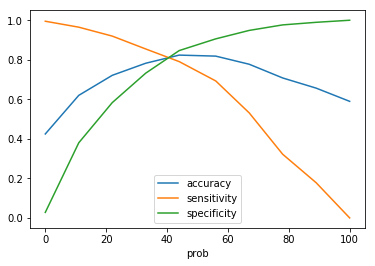

In [204]:
cutoff_df1 = pd.DataFrame( columns = ['prob','accuracy','sensitivity','specificity'])
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(25,10))
num = np.around(np.linspace(0, 100, 10),decimals=0)
for i in num:
    cm1 = metrics.confusion_matrix(y_pred_final.churn, y_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df1.loc[i] =[ i ,accuracy,sensi,speci]
cutoff_df1.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

In [205]:
cutoff_df.sort_values(by=['accuracy'],ascending=False,inplace=True)
print(cutoff_df.head(20))

      prob  accuracy  sensitivity  specificity
44.0  44.0  0.823650     0.790727     0.846556
52.0  52.0  0.822622     0.724311     0.891020
45.0  45.0  0.822108     0.778195     0.852659
53.0  53.0  0.822108     0.716792     0.895379
51.0  51.0  0.821594     0.731830     0.884045
57.0  57.0  0.820566     0.690476     0.911072
54.0  54.0  0.820566     0.710526     0.897123
55.0  55.0  0.820051     0.704261     0.900610
48.0  48.0  0.819537     0.755639     0.863993
43.0  43.0  0.819537     0.802005     0.831735
47.0  47.0  0.819023     0.760652     0.859634
56.0  56.0  0.818509     0.692982     0.905841
58.0  58.0  0.817995     0.679198     0.914560
49.0  49.0  0.817995     0.744361     0.869224
46.0  46.0  0.817995     0.765664     0.854403
42.0  42.0  0.816967     0.808271     0.823017
41.0  41.0  0.811825     0.813283     0.810811
59.0  59.0  0.810283     0.655388     0.918047
40.0  40.0  0.808226     0.819549     0.800349
60.0  60.0  0.805141     0.639098     0.920663


In [206]:
cutoff_df.sort_values(by=['sensitivity'],ascending=False,inplace=True)
print(cutoff_df.head(30))

      prob  accuracy  sensitivity  specificity
0.0    0.0  0.424679     0.994987     0.027899
1.0    1.0  0.457069     0.989975     0.086312
2.0    2.0  0.474550     0.989975     0.115955
3.0    3.0  0.495116     0.986216     0.153444
4.0    4.0  0.519794     0.984962     0.196164
5.0    5.0  0.535219     0.979950     0.225806
6.0    6.0  0.554756     0.977444     0.260680
7.0    7.0  0.571722     0.977444     0.289451
8.0    8.0  0.587147     0.974937     0.317350
9.0    9.0  0.602571     0.974937     0.343505
10.0  10.0  0.609769     0.971178     0.358326
11.0  11.0  0.620051     0.964912     0.380122
12.0  12.0  0.630848     0.961153     0.401046
13.0  13.0  0.643188     0.958647     0.423714
14.0  14.0  0.653985     0.956140     0.443766
15.0  15.0  0.662211     0.954887     0.458588
16.0  16.0  0.674550     0.949875     0.482999
17.0  17.0  0.682776     0.946115     0.499564
18.0  18.0  0.689460     0.942356     0.513514
19.0  19.0  0.701799     0.939850     0.536181
20.0  20.0  0

### Since we are aggressively trying to predict the churners, the Sensitivity should be maximized
- Overall the model gives 82% accuracy at best, with threshold value as 63. Sensitivity = 72%
- To maximize sensitivity, the threshold can be 19, where sensitivity is 94%. Accuracy = 70%

In [207]:
final_pred=y_pred_final[['Score','churn']]
final_pred['Predicted_Churn']=final_pred.Score.map(lambda x:1 if x>19 else 0)
final_pred.head(10)

,Score,churn,Predicted_Churn
0,79,1,1
1,24,0,1
2,49,1,1
3,34,0,1
4,5,0,0
5,66,1,1
6,53,0,1
7,7,0,0
8,39,1,1
9,23,0,1


### Logistic Regression report - 
-  Best accuracy possible - 82% ; Sensitivity = 72%
- selected accuracy - 70% to increase Sensitivity to 94%

# Random Forest - default params

In [208]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()
#    'max_depth': None
#    'min_samples_leaf': 2
#    'min_samples_split': 2
#    'n_estimators': 10
#    'max_features': auto = sqrt(n_features)

In [209]:
# fit
rfc.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [210]:
# Making predictions
predictions = rfc.predict(X_test)

In [211]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
print(accuracy_score(y_test,predictions))

0.826735218509


## RF - Individual Hyper parameter tuning

In [212]:
# MAX_DEPTH
param_grid = {
    'max_depth': [5,6,7,8,9,10,12,14,15]
}
# Create a based model
rf1 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring="accuracy",
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   10.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 7, 8, 9, 10, 12, 14, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

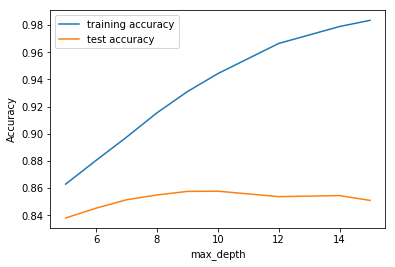

,param_max_depth,mean_test_score
5,10,0.857760
4,9,0.857606
3,8,0.854983
7,14,0.854520
6,12,0.853749
2,7,0.851435
8,15,0.850972
1,6,0.845264
0,5,0.838013


In [213]:
# scores of GridSearch CV
scores = grid_search.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_max_depth','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [216]:
# MIN LEAF SAMPLES 
param_grid = {
    'min_samples_leaf': range(50,400,30)
}
# Create a based model
rf1 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring="accuracy",
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:    8.4s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': range(50, 400, 30)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

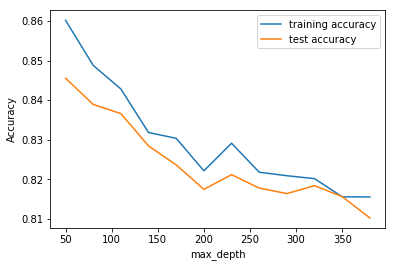

,param_min_samples_leaf,mean_test_score
0,50,0.845572
1,80,0.838939
2,110,0.836624
3,140,0.828448
4,170,0.823666
6,230,0.821197
9,320,0.818420
7,260,0.817803
5,200,0.817495
8,290,0.816415


In [217]:
# scores of GridSearch CV
scores = grid_search.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_min_samples_leaf','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [218]:
# n-estimators 
param_grid = {
    'n_estimators': [50,100,150,200,250,300]
}
# Create a based model
rf1 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring="accuracy",
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [50, 100, 150, 200, 250, 300]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

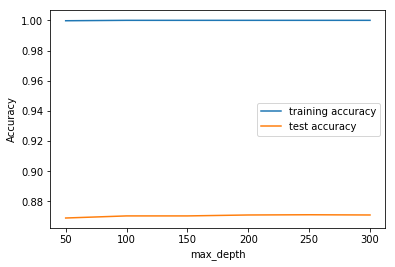

,param_n_estimators,mean_test_score
4,250,0.871182
3,200,0.871027
5,300,0.871027
1,100,0.870410
2,150,0.870410
0,50,0.869022


In [219]:
# scores of GridSearch CV
scores = grid_search.cv_results_
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_n_estimators','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [69]:
# max_features
param_grid = {
    'max_features': range(5,100,10)
}
# Create a based model
rf1 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring="accuracy",
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   33.1s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_features': range(5, 100, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

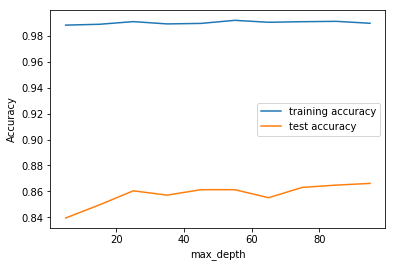

,param_max_features,mean_test_score
9,95,0.866211
8,85,0.864889
7,75,0.863125
4,45,0.861362
5,55,0.861362
2,25,0.860480
3,35,0.857174
6,65,0.855191
1,15,0.849680
0,5,0.839542


In [70]:
# scores of GridSearch CV
scores = grid_search.cv_results_
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_max_features','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

In [71]:
# min_samples_split
param_grid = {
    'min_samples_split': range(5,120,10)
}
# Create a based model
rf1 = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf1,
                           param_grid = param_grid, 
                           cv = 5,
                           scoring="accuracy",
                           verbose = 1)
# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   11.3s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(5, 120, 10)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=1)

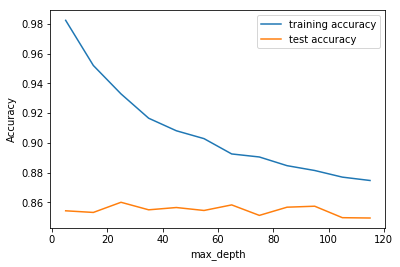

,param_min_samples_split,mean_test_score
2,25,0.860040
6,65,0.858276
9,95,0.857395
8,85,0.856734
4,45,0.856513
3,35,0.854970
5,55,0.854529
0,5,0.854309
1,15,0.853207
7,75,0.851223


In [72]:
# scores of GridSearch CV
scores = grid_search.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results[['param_min_samples_split','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

## RF - All Hyper parameter tuning

In [223]:
# model with the best hyperparameters
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(bootstrap=True,
                             max_depth=9,
                             min_samples_leaf=50, 
                             min_samples_split=25,
                             max_features=55,
                             n_estimators=200)

In [224]:
# fit
rfc.fit(X_train,y_train)
# Making predictions
predictions = rfc.predict(X_test)

In [225]:
from sklearn.metrics import classification_report,confusion_matrix
cm1=confusion_matrix(y_test,predictions)
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("sensitivity=",sensi)
print("specificity=",speci)
print("accuracy=",accuracy)

sensitivity= 0.785714285714
specificity= 0.917175239756
accuracy= 0.86323907455


# SVM implementation

### Data check for churn population percentage

In [226]:
print(y_train.mean())
print(y_test.mean())

0.3956358827418999
0.4102827763496144


### SVM - linear 

In [227]:
model = SVC(C = 1)

# fit
model.fit(X_train, y_train)

# predict
y_pred_SVM = model.predict(X_test)

In [228]:
from sklearn.metrics import classification_report,confusion_matrix
cm1=confusion_matrix(y_test,y_pred_SVM)
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("sensitivity=",sensi)
print("specificity=",speci)
print("accuracy=",accuracy)

sensitivity= 0.437343358396
specificity= 0.944202266783
accuracy= 0.736246786632


### Hyperparameter Tuning

In [229]:
# specify range of parameters (C) as a list
params = {"C": [0.01, 0.1, 1, 10, 100, 500]}

model = SVC()

# set up grid search scheme
# note that we are still using the 5 fold CV scheme we set up earlier
model_cv = GridSearchCV(estimator = model, 
                        param_grid = params, 
                        scoring= 'accuracy', 
                        cv = 5, 
                        verbose = 1,
                       return_train_score=True)  
# fit the model - it will fit 5 folds across all values of C
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  2.3min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.01, 0.1, 1, 10, 100, 500]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

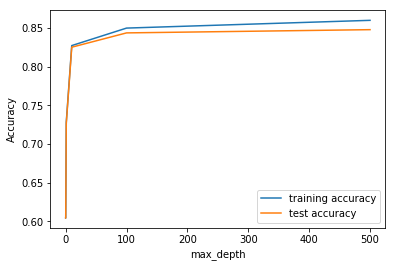

,param_C,mean_test_score
5,500,0.848138
4,100,0.843950
3,10,0.825435
2,1,0.726692
0,0.01,0.604364
1,0.1,0.604364


In [230]:
# results of grid search CV
# scores of GridSearch CV
scores = model_cv.cv_results_
plt.figure()
plt.plot(scores["param_C"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_C"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results[['param_C','mean_test_score']].sort_values(by='mean_test_score',ascending=False)

### SVM - linear - best model implementation

In [231]:
model = SVC(C = 100)

# fit
model.fit(X_train, y_train)

# predict
y_pred_SVM = model.predict(X_test)

In [232]:
from sklearn.metrics import classification_report,confusion_matrix
cm1=confusion_matrix(y_test,y_pred_SVM)
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("sensitivity=",sensi)
print("specificity=",speci)
print("accuracy=",accuracy)

sensitivity= 0.780701754386
specificity= 0.884045335658
accuracy= 0.841645244216


### SVM - non linear

In [91]:
model = SVC(C = 1, kernel='rbf')
model.fit(X_train, y_train)
y_pred_SVM_NL = model.predict(X_test)

In [92]:
cm1=confusion_matrix(y_test,y_pred_SVM_NL)
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("sensitivity=",sensi)
print("specificity=",speci)
print("accuracy=",accuracy)

sensitivity= 0.437343358396
specificity= 0.944202266783
accuracy= 0.736246786632


### Hyperparameter tuning

In [100]:
# creating a KFold object with 5 splits 
folds = KFold(n_splits = 5, shuffle = True, random_state = 4)

# specify range of hyperparameters
# Set the parameters by cross-validation
hyper_params = [ {'gamma': [1e-2, 1e-3, 1e-4],
                     'C': [10, 100, 500]}]


# specify model
model = SVC(kernel="rbf")

# set up GridSearchCV()
model_cv_SVMNL = GridSearchCV(estimator = model, 
                        param_grid = hyper_params, 
                        scoring= 'accuracy', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv_SVMNL.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:  3.1min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
       error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'gamma': [0.01, 0.001, 0.0001], 'C': [10, 100, 500]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [101]:
# results of grid search CV
# printing the optimal accuracy score and hyperparameters
best_score = model_cv_SVMNL.best_score_
best_hyperparams = model_cv_SVMNL.best_params_

print("The best test score is {0} corresponding to hyperparameters {1}".format(best_score, best_hyperparams))

The best test score is 0.846815076041437 corresponding to hyperparameters {'C': 500, 'gamma': 0.01}


### The score ~84%; in both linear and Non-linear; hence selected Linear SVM as the best SVM model

# DECISION TREE IMPLEMENTATION

### Hyperparameter tuning

In [78]:
from sklearn.tree import DecisionTreeClassifier
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 40)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': range(2, 40)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

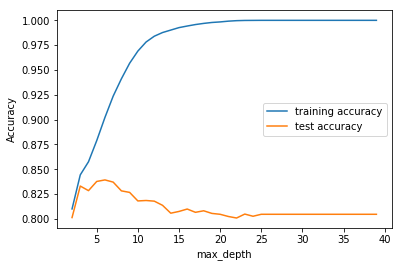

,param_max_depth,mean_test_score
4,6,0.839321
3,5,0.837778
5,7,0.837117
1,3,0.833150
2,4,0.828521


In [83]:
# scores of GridSearch CV
scores = tree.cv_results_
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(tree.cv_results_)
cv_results[['param_max_depth','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head()

In [84]:
from sklearn.tree import DecisionTreeClassifier
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_leaf': range(5, 200, 20)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

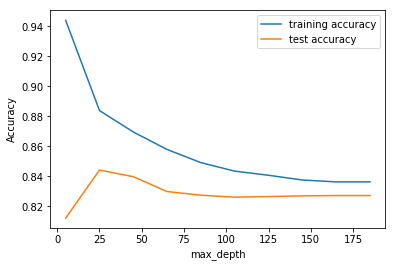

,param_min_samples_leaf,mean_test_score
1,25,0.844170
2,45,0.839762
3,65,0.829844
4,85,0.827419
8,165,0.827199


In [85]:
# scores of GridSearch CV
scores = tree.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(tree.cv_results_)
cv_results[['param_min_samples_leaf','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head()

In [86]:
from sklearn.tree import DecisionTreeClassifier
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(25, 150, 25)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy")
tree.fit(X, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'min_samples_split': range(25, 150, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

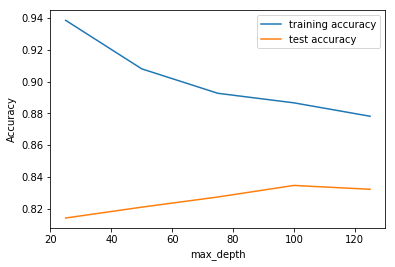

,param_min_samples_split,mean_test_score
3,100,0.834693
4,125,0.832268
2,75,0.827419
1,50,0.821027
0,25,0.814194


In [87]:
# scores of GridSearch CV
scores = tree.cv_results_
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
cv_results = pd.DataFrame(tree.cv_results_)
cv_results[['param_min_samples_split','mean_test_score']].sort_values(by='mean_test_score',ascending=False).head()

### Grid Search for over all fit

In [89]:
# Create the parameter grid 
param_grid = {
    'max_depth': [5,6,10],
    'min_samples_leaf': [25,45,65],
    'min_samples_split': [75,100,125],
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X,y)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=1)]: Done 270 out of 270 | elapsed:  1.7min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [5, 6, 10], 'min_samples_leaf': [25, 45, 65], 'min_samples_split': [75, 100, 125], 'criterion': ['entropy', 'gini']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [90]:
# printing the optimal accuracy score and hyperparameters
print("best accuracy", grid_search.best_score_)
print("best estimator:",grid_search.best_estimator_)

best accuracy 0.850971922246
best estimator: DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=125,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


### implementing the best possible decision tree

In [93]:
# model with optimal hyperparameters
dtree_fnl = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=25,
                                  min_samples_split=125)
dtree_fnl.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=25, min_samples_split=125,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [94]:
predictions_dt = dtree_fnl.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
cm1=confusion_matrix(y_test,predictions_dt)
total1=sum(sum(cm1))
accuracy = (cm1[0,0]+cm1[1,1])/total1
speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
print("sensitivity=",sensi)
print("specificity=",speci)
print("accuracy=",accuracy)

sensitivity= 0.781954887218
specificity= 0.90235396687
accuracy= 0.852956298201


# OVERALL REPORT

### Logistic Regression report - 
-  Best accuracy possible - 82% ; Sensitivity = 72%
- selected accuracy - 70% to increase Sensitivity to 94%

### Support Vector Machine report - 
- sensitivity= 0.780701754386
- specificity= 0.884045335658
- accuracy= 0.841645244216

### Decision Tree
- sensitivity= 0.781954887218
- specificity= 0.90235396687
- accuracy= 0.852956298201

### Random Forest report - 
- sensitivity= 0.78320802005
- specificity= 0.916303400174
- accuracy= 0.861696658098

## Random Forest gives the best accuracy; but using the Logistic Regression we have the option of selecting a score that can give us better SENSITIVITY by compromising with accuracy.
## The selection of Random Forrest or LOGIT will depend on the business requirement - 
- whether better accuracy is required or,
- better sensitivity is required

# *** DRIVER ANALYSIS MODEL ****

## Implementing Decision Tree for Driver Analysis

In [235]:
from sklearn.utils import resample

# Separate majority and minority classes
HVItelco_majority = HVItelco[HVItelco.churn==0]
HVItelco_minority = HVItelco[HVItelco.churn==1]
 
# Downsample majority class
HVItelco_majority_downsampled2 = resample(HVItelco_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=3889,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
HVItelco_downsampled2 = pd.concat([HVItelco_majority_downsampled2, HVItelco_minority])
 
# Display new class counts
HVItelco_downsampled2.churn.value_counts()

0    3889
1    2593
Name: churn, dtype: int64

In [236]:
dep=HVItelco_downsampled2['churn']
drvr=HVItelco_downsampled2
driver=drvr.drop(['churn'],axis=1)
delcols=list(HVItelco1.filter(like='date_of_last_rech').columns)
delcols.append('mobile_number')
driver.drop(delcols,axis=1,inplace=True)

In [237]:
from sklearn.tree import DecisionTreeClassifier

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt_default = DecisionTreeClassifier(max_depth=3)
dt_default.fit(driver, dep)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [238]:
# Importing required packages for visualization
from IPython.display import Image  
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus, graphviz

In [239]:
# Specifing path for dot file.
import os
os.environ["PATH"] += os.pathsep + 'C:\\Program Files (x86)\\Graphviz2.38\\bin\\'

# Putting features
features = list(driver.columns)

# plotting tree with max_depth=3
dot_data = StringIO()  
export_graphviz(dt_default, out_file=dot_data,
                feature_names=features, filled=True,rounded=True)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("dt_churn.pdf")

# the pdf with the tree will be written in this directory on your system
import os
os.getcwd()

'C:\\Users\\soumi\\Documents\\Upgrad\\Predictive Analytics II\\Assignment\\Group Study_Telecom Churn'

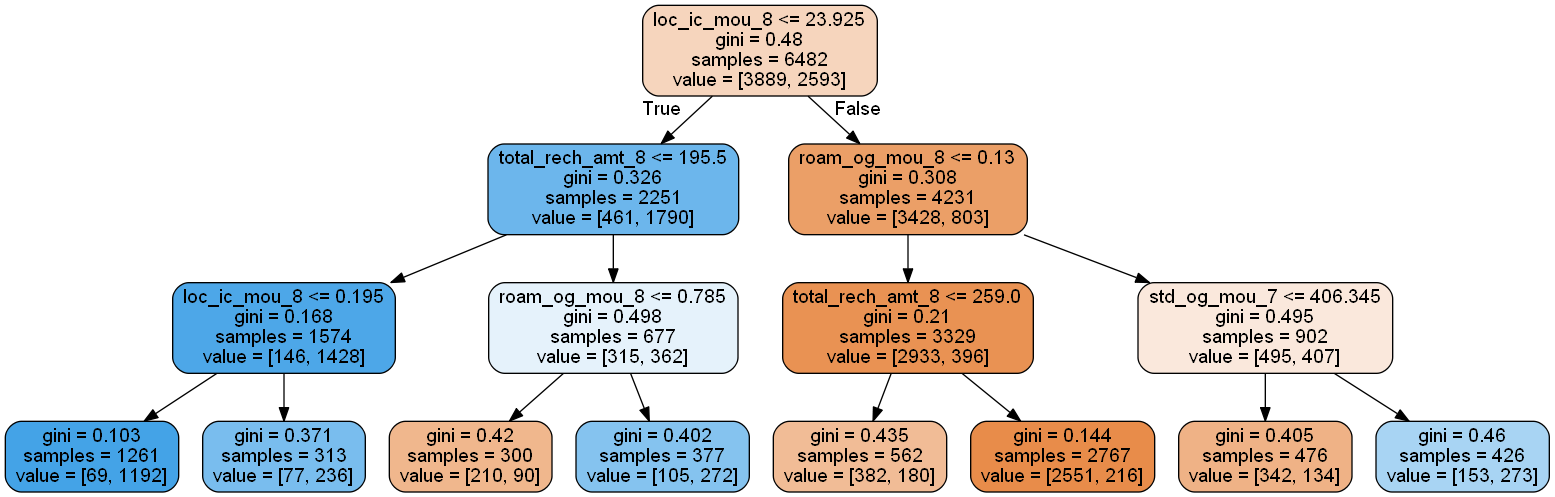

In [242]:
Image(graph.create_png())

,value
feature,
loc_ic_mou_8,0.704115
roam_og_mou_8,0.138879
total_rech_amt_8,0.119690
std_og_mou_7,0.037316


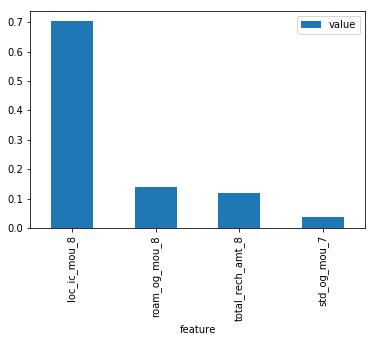

In [243]:
values=pd.DataFrame(dt_default.feature_importances_)
features1=pd.DataFrame(features)
feature_all =pd.concat([features1, values], axis=1)
feature_all.columns = ['feature', 'value']
feature_all.set_index('feature',inplace=True)
feature_imp = feature_all.loc[feature_all.value != 0]
feature_imp.sort_values(by='value',ascending=False,inplace=True)
feature_imp.plot.bar()
feature_imp

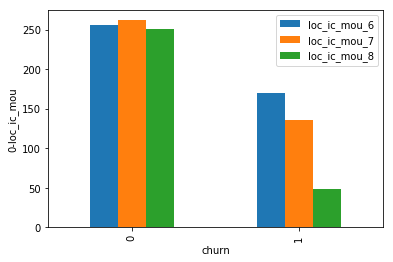

       loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  rateoffall
churn                                                      
0        256.344196    261.722561    250.724250    0.032077
1        169.635492    135.208199     48.692603    0.680541


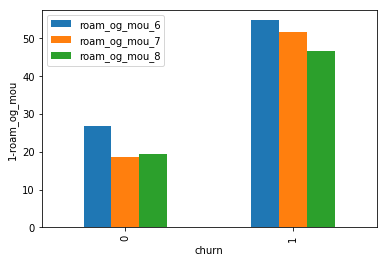

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  rateoffall
churn                                                         
0          26.659895      18.478092      19.446889    0.138336
1          54.650613      51.683413      46.473051    0.125904


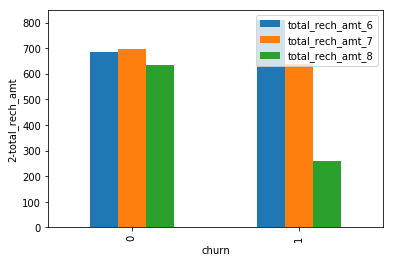

       total_rech_amt_6  total_rech_amt_7  total_rech_amt_8  rateoffall
churn                                                                  
0            685.676524        696.010285        632.183852    0.084910
1            808.441188        637.946008        258.846895    0.642078


In [244]:
driverKPI=['loc_ic_mou','roam_og_mou','total_rech_amt']
count=0
HVItelco_downsampled_analysis=HVItelco_downsampled.groupby('churn')
for i in range(3):
        cols=list(HVItelco_downsampled.filter(like=driverKPI[count]).columns)
        plotdata=HVItelco_downsampled_analysis[cols].mean()
        plt.figure
        plotdata.plot.bar()
        plt.ylabel(str(count)+"-"+str(driverKPI[count]))
        plt.show()
        plotdata['rateoffall']=(((plotdata[cols[0]]+plotdata[cols[1]])/2)-plotdata[cols[2]])/((plotdata[cols[0]]+plotdata[cols[1]])/2)
        print(plotdata)                                                                                
        count=count+1

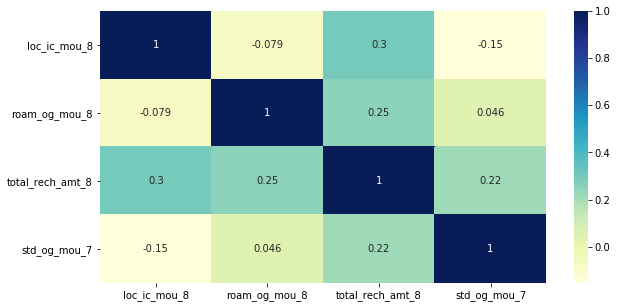

In [245]:
feature_imp.reset_index(inplace=True)
# plotting correlations on a heatmap
cols=list(feature_imp['feature'])
Multicoll=HVItelco_downsampled[cols]
# figure size
plt.figure(figsize=(10,5))

# heatmap
sns.heatmap(Multicoll.corr(), cmap="YlGnBu", annot=True)
plt.show()

#### There is no significant multi collinearity between the driver variables

## Report Of Driver variables

The following are the main indicator variables towards churn are:
    - local income minutes of usage for the 'action' month (8th) - drastic fall of ~64%
    - roaming outgoing minutes of usage  for the 'action' month (8th) - usage rate of this KPI is significantly higher for churners compared to non-churners
    - total recharge amount for the 'action' month (8th) - drastic fall of ~68%

Recommendations
-  Monitor the local income minutes in the action month. If it is showing a drastic fall from previous month average then, it can mean the customer is about to churn
- Check if roaming usage is very high than the total population. Roaming users run a greater risk of churning
- Monitor the total recharge amount done in the 'action' month - if it falls drastically then, there is a possibility of churn